# **Machine Learning: Project Part 2 - Seal Call Discrimination**

---

**Author: Damien Farrell**

---


### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

---

#### **Step A: Data Pre-processing**

This step is completed in notebook `A. data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**

This part is completed in notebook `B. model_selection.ipynb`.

#### **Step C: Refine Model**
1. **Parameter Tuning**:
   - Using Kera tuner to tune hyperparmeters.

2. **Test Evaluation**:
   - Evaluating on the test set.

---

### **Step C: Refine Model** 

---

In [51]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras.backend as K
import keras_tuner as kt

I decided to use the CNN as it performed well and could be tuned more than the LGBM.

In [52]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

Setting the data up again.

In [53]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)

# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

(2796,)
(2796, 42, 84)


#### **Model: CNN**

In [57]:
# Define focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [58]:
# Early stopping
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

Build model function for Keras Tuner

In [59]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(42, 84, 1)))
    
    # Add convolutional layers
    for i in range(hp.Int("conv_layers", 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f"filters_{i}", min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5]),
            padding="same",
            activation=None
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation("relu"))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(hp.Float(f"dropout_conv_{i}", 0.0, 0.5, 0.1)))

    # Add convolutional layers
    for i in range(hp.Int("conv_layers", 1, 3)):
    model.add(layers.Conv2D(
        filters=hp.Int(f"filters_{i}", min_value=16, max_value=128, step=16),
        kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5]),
        padding="same",
        activation=None
    ))
    # GlobalAveragePooling2D (or Flatten)
    model.add(layers.GlobalAveragePooling2D())
    
    # Add dense layers
    for d in range(hp.Int("dense_layers", 1, 2)):  # e.g. 1-2 dense layers
        model.add(layers.Dense(
            units=hp.Int(f"dense_units_{d}", 64, 256, 32),
            activation="relu"
        ))
        model.add(layers.Dropout(hp.Float(f"dropout_dense_{d}", 0.0, 0.5, 0.1)))
    
    num_classes = len(np.unique(stratify_labels))
    model.add(layers.Dense(num_classes, activation="softmax"))

    # Choose loss
    loss_type = hp.Choice("loss_type", ["focal", "categorical_crossentropy"])
    if loss_type == "focal":
        chosen_loss = focal_loss(gamma=2.0, alpha=0.25)
    else:
        chosen_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    # Choose optimizer & LR
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile
    model.compile(
        optimizer=optimizer,
        loss=chosen_loss,
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
            tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
            tf.keras.metrics.AUC(multi_label=False, name="auc"),
            tf.keras.metrics.F1Score(threshold=0.5, average="macro", name="f1_score"),
        ],
    )
    return model

In [60]:
# Data
X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]].values

# `y` contains one-hot encoded labels
stratify_labels = np.argmax(y, axis=1)

In [61]:
# First split: Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True
)

# Create new labels for X_train/y_train only
stratify_labels_train = np.argmax(y_train, axis=1)

# Then split into Train/Val
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=stratify_labels_train,
    shuffle=True
)

In [62]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_epochs=50,
    factor=3,
    directory="tuner_results",
    project_name="spectrogram_tuning",
)

#tuner = kt.BayesianOptimization(
#    build_model,
#    objective="val_accuracy",
#    max_trials=20,  # Explicit number of trials
#    directory="tuner_results",
#    project_name="bayesian_search",
#)

In [63]:
tuner.search(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_callback]
)

Trial 90 Complete [00h 01m 19s]
val_f1_score: 0.6350319981575012

Best val_f1_score So Far: 0.7171358466148376
Total elapsed time: 00h 43m 10s


In [64]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

for key, value in best_hp.values.items():
    print(f"{key}: {value}")

conv_layers: 2
filters_0: 96
kernel_size_0: 5
dense_units: 224
loss_type: categorical_crossentropy
learning_rate: 0.001
filters_1: 64
kernel_size_1: 5
filters_2: 32
kernel_size_2: 3
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0077


In [65]:
# build and evaluate the "best model" on the validation set
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_callback]
)
val_results = best_model.evaluate(X_val, y_val, verbose=0, return_dict=True)
print("Validation Results after Tuning:", val_results)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4780 - auc: 0.8066 - f1_score: 0.1353 - loss: 15.0603 - precision: 0.6739 - recall: 0.1836 - val_accuracy: 0.5546 - val_auc: 0.8976 - val_f1_score: 0.2663 - val_loss: 1.2265 - val_precision: 0.8089 - val_recall: 0.3256
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.6541 - auc: 0.9248 - f1_score: 0.3267 - loss: 0.9974 - precision: 0.7907 - recall: 0.5005 - val_accuracy: 0.7710 - val_auc: 0.9617 - val_f1_score: 0.4254 - val_loss: 0.6930 - val_precision: 0.8463 - val_recall: 0.7191
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8035 - auc: 0.9666 - f1_score: 0.4830 - loss: 0.6185 - precision: 0.8544 - recall: 0.7354 - val_accuracy: 0.8444 - val_auc: 0.9704 - val_f1_score: 0.5189 - val_loss: 0.6002 - val_precision: 0.8735 - val_recall: 0.7782
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8070 - auc: 0.9740 - f1_score: 0.5156 - loss: 0.5617 - precision: 0.8438 - recall: 0.

In [66]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []

for fold_idx, (train_index, val_index) in enumerate(kf.split(X, stratify_labels), 1):
    print(f"\n--- Fold {fold_idx} ---")
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Build a new model with the best hyperparameters from the tuner
    model_cv = tuner.hypermodel.build(best_hp)

    # You could use a different patience if you like
    early_stop_cv = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the best model on this fold
    history = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=20,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[early_stop_cv],
        verbose=1,
    )

    # Evaluate on the validation portion of this fold
    results = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0, return_dict=True)
    fold_accuracies.append(results["accuracy"])
    fold_f1_scores.append(results["f1_score"])

    K.clear_session()


--- Fold 1 ---
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.4975 - auc: 0.8292 - f1_score: 0.1801 - loss: 99.7957 - precision: 0.6807 - recall: 0.2574 - val_accuracy: 0.5268 - val_auc: 0.8699 - val_f1_score: 0.1125 - val_loss: 1.2722 - val_precision: 0.8737 - val_recall: 0.1482
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6217 - auc: 0.9091 - f1_score: 0.2362 - loss: 2.3252 - precision: 0.8231 - recall: 0.3584 - val_accuracy: 0.7643 - val_auc: 0.9630 - val_f1_score: 0.4362 - val_loss: 0.6748 - val_precision: 0.8337 - val_recall: 0.6893
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7582 - auc: 0.9630 - f1_score: 0.4365 - loss: 0.6791 - precision: 0.8032 - recall: 0.6698 - val_accuracy: 0.8143 - val_auc: 0.9684 - val_f1_score: 0.5091 - val_loss: 0.5922 - val_precision: 0.8462 - val_recall: 0.7661
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8256 - auc: 0.9753 - f1_score: 0.5265 - loss: 0.5267 - precision: 0.8

In [67]:
print(f"\nAvg accuracy over folds: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Avg F1 over folds:       {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


Avg accuracy over folds: 0.8505 ± 0.0963
Avg F1 over folds:       0.5407 ± 0.1335


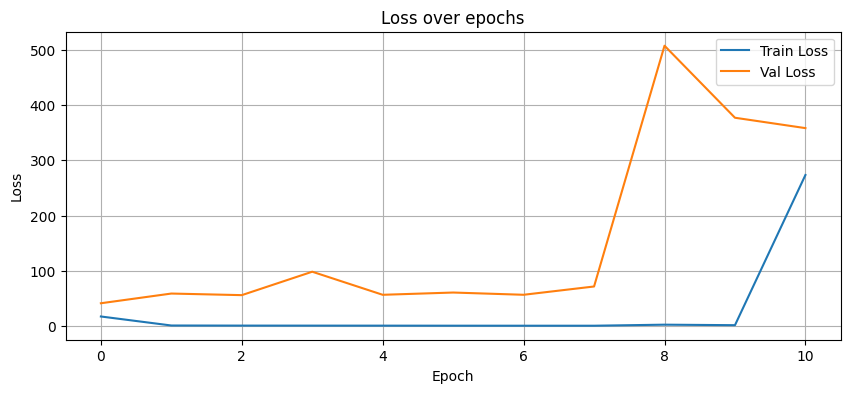

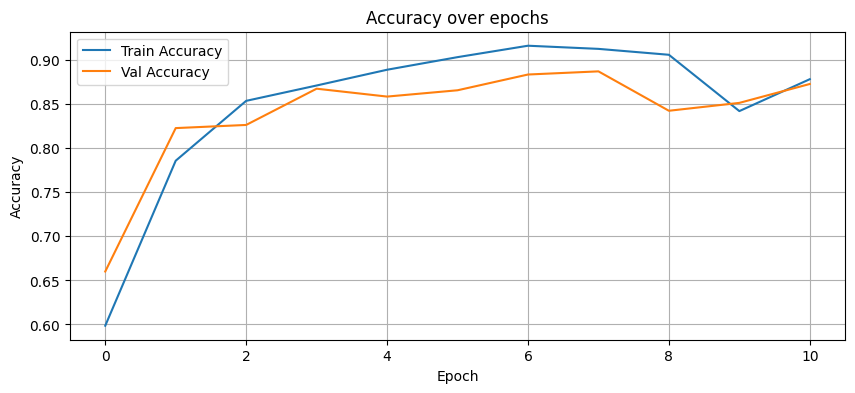

In [68]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training & validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       145
           1       0.69      0.80      0.74        85
           2       0.96      1.00      0.98       186
           3       0.89      0.84      0.86       101
           4       0.49      0.55      0.51        33
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         4

    accuracy                           0.84       559
   macro avg       0.55      0.57      0.56       559
weighted avg       0.84      0.84      0.84       559



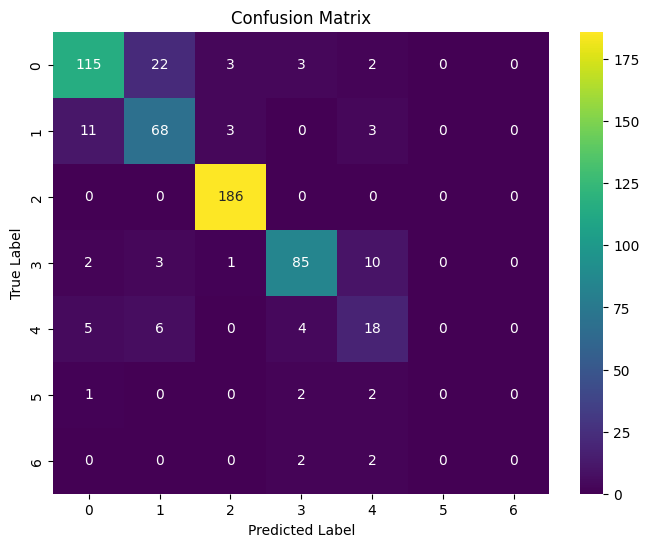

In [69]:
# Predict on the validation set
y_pred_probs = best_model.predict(X_val)

# Convert probabilities to predicted class indices
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Convert one-hot true labels to class indices
y_true_labels = np.argmax(y_val, axis=1)

# Classification report
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true_labels, 
                            y_pred_labels,
                            zero_division=0
                            ))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=np.unique(y_true_labels), 
            yticklabels=np.unique(y_true_labels), 
            cmap="viridis")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

### **Test Set Evaluation**

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       145
           1       0.71      0.71      0.71        85
           2       0.99      0.99      0.99       187
           3       0.90      0.88      0.89       100
           4       0.48      0.70      0.57        33
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5

    accuracy                           0.86       560
   macro avg       0.56      0.59      0.57       560
weighted avg       0.85      0.86      0.85       560



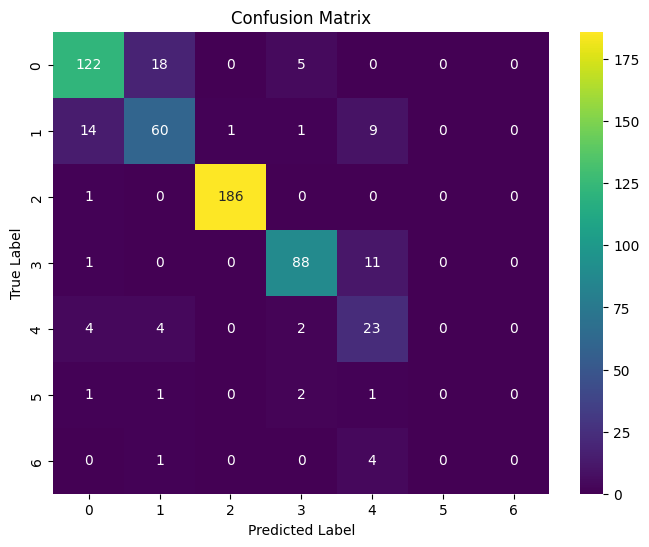

In [70]:
y_test_pred_probs = best_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_test_true_labels, 
                            y_test_pred_labels,
                            zero_division=0
                            ))

# Confusion matrix
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=np.unique(y_test_true_labels), 
            yticklabels=np.unique(y_test_true_labels), 
            cmap="viridis")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [71]:
final_test_results = best_model.evaluate(X_test, y_test, verbose=0, return_dict=True)
print("\nFinal Test Metrics:")
for metric_name, metric_value in final_test_results.items():
    print(f"{metric_name}: {metric_value:.4f}")


Final Test Metrics:
accuracy: 0.8554
auc: 0.9728
f1_score: 0.5778
loss: 740.3164
precision: 0.8734
recall: 0.8500


---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)
1.
1.
1.
1.
1.
1.
1.
1.





---

# END